# Matrix Completion


Import of libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

Algorithm for solving matrix completion:

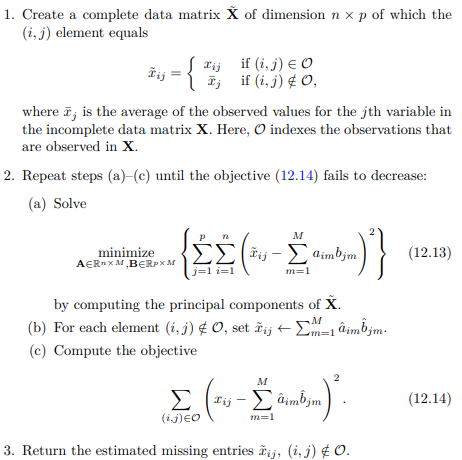

method for computing PSA using SVD using first M components, default value is 1



In [ ]:
def low_rank(X, M=1):
    U, D, V = np.linalg.svd(X)
    L = U[:,:M] * D[None,:M]
    return L.dot(V[:M])

Loading datasets

In [ ]:
# here is dataset without missing values
url = 'https://drive.google.com/file/d/1NrmXxD7e_sDN3Bgfi5wUeMGArP47pzLh/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
print(path)
X = pd.read_csv(path, header=0, index_col=0)

https://drive.google.com/uc?export=download&id=1NrmXxD7e_sDN3Bgfi5wUeMGArP47pzLh


In [ ]:
# here is dataset with missing values
url = 'https://drive.google.com/file/d/11N8IWALnhEwTO8dA1HTpYXUcfvD0tMBe/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
print(path)
Xna = pd.read_csv(path, header=0, index_col=0)

https://drive.google.com/uc?export=download&id=11N8IWALnhEwTO8dA1HTpYXUcfvD0tMBe


Step number one from algorithm; creating complete matrix using avarage of values of columns from nonmissing values

In [ ]:
# scale the data first
scaler = StandardScaler(with_mean=True, with_std=True)
Xna_scaled = scaler.fit_transform(Xna)

nan_indices = np.where(pd.isna(Xna_scaled))
r_idx = np.array(nan_indices[0])
c_idx = np.array(nan_indices[1])

Xhat = Xna_scaled.copy()
Xbar = np.nanmean(Xhat, axis=0)
Xhat[r_idx, c_idx] = Xbar[c_idx]

variables for measuring progress of optimalization

In [ ]:
thresh = 1e-7 # threshold
rel_err = 1 # relative error, we will look if relative error is smaller than threshold in optimalization
count = 0 # count of iterations
ismiss = np.isnan(Xna_scaled) # boolean matrix - same shape as Xna -> True if value is missing -> False if values is non missing
mssold = np.mean(Xhat[~ismiss]**2) #  the mean squared error of the non-missing elements of the old version of Xhat
mss0 = np.mean(Xna_scaled[~ismiss]**2) # the mean of the squared non-missing elements

Step number two from algorithm

In [ ]:
# number of principal components we would like to use
M = 1

while rel_err > thresh:
    count += 1
    # Step 2a - approximate Xhat using low_rank() function into Xapp
    Xapp = low_rank(Xhat, M)
    # Step 2b - use Xapp to update the estimates for elements in Xhat that are missing in Xna
    Xhat[ismiss] = Xapp[ismiss]
    # Step 2c - computing the relative error
    mss = np.mean(((Xna_scaled - Xapp)[~ismiss])**2) # the mean squared error of the non-missing elements of the current version of Xhat
    rel_err = (mssold - mss) / mss0
    mssold = mss
    print("Iteration: {0}, MSS:{1:.3f}, Rel.Err {2:.2e}"
    .format(count, mss, rel_err))

Iteration: 1, MSS:0.455, Rel.Err 5.45e-01
Iteration: 2, MSS:0.447, Rel.Err 7.83e-03
Iteration: 3, MSS:0.446, Rel.Err 7.53e-04
Iteration: 4, MSS:0.446, Rel.Err 1.32e-04
Iteration: 5, MSS:0.446, Rel.Err 3.28e-05
Iteration: 6, MSS:0.446, Rel.Err 1.00e-05
Iteration: 7, MSS:0.446, Rel.Err 3.47e-06
Iteration: 8, MSS:0.446, Rel.Err 1.29e-06
Iteration: 9, MSS:0.446, Rel.Err 5.02e-07
Iteration: 10, MSS:0.446, Rel.Err 2.00e-07
Iteration: 11, MSS:0.446, Rel.Err 8.13e-08


rescaling dataframes


In [ ]:
scaler = StandardScaler(with_mean=True, with_std=True)
Xna_scaled = scaler.fit_transform(Xna)
X_scaled = scaler.fit_transform(X)
Xhat_unscaled = scaler.inverse_transform(Xhat)

computing correlation between imputed values and original values

In [ ]:
np.corrcoef(Xapp[ismiss], X_scaled[ismiss])[0,1]

0.7690102037454875

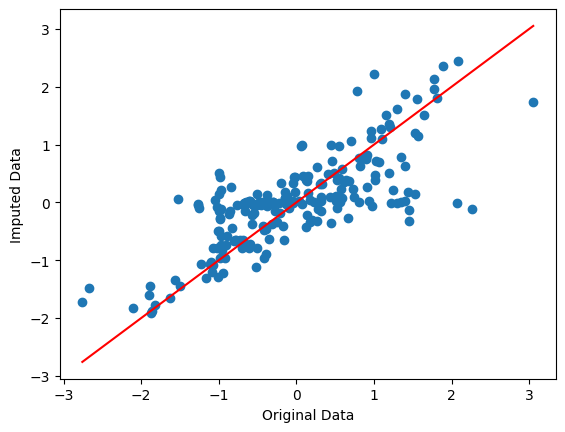

In [ ]:
plotResults(X, Xhat_unscaled, True, nan_indices)

In [ ]:
# as an input shoud goes both unscaled data - original with non missing values and apporximate data with estimated values
def plotResults(origin_data, approximate_data, scale,nan_indices):
    if (scale):
        # rescale both data at first
        scaler = StandardScaler(with_mean=True, with_std=True)
        origin_data = scaler.fit_transform(origin_data)
        approximate_data = scaler.fit_transform(approximate_data)

        origin_values = origin_data[nan_indices[0], nan_indices[1]]
        approximate_values = approximate_data[nan_indices[0], nan_indices[1]]

        plt.scatter(origin_values, approximate_values)
    else:
        origin_values = origin_data.values[nan_indices]
        approximate_values = approximate_data[nan_indices[0], nan_indices[1]]

        plt.scatter(origin_values, approximate_values)

    # takes maximum and minimum of both data
    p_max = max(np.max(origin_values), np.max(approximate_values))
    p_min = min(np.min(origin_values), np.min(approximate_values))

    # Plot the red line with dynamic limits
    plt.plot([p_min, p_max], [p_min, p_max], "r-")
    plt.xlabel("Original Data")
    plt.ylabel("Imputed Data")
    plt.show()

Whole algorithm in one function:

In [ ]:
def approximate_missing_values(data, M, thresh):
  # scale the data first
  scaler = StandardScaler(with_mean=True, with_std=True)
  Xna_scaled = scaler.fit_transform(data)

  nan_indices = np.where(pd.isna(Xna_scaled))
  r_idx = np.array(nan_indices[0])
  c_idx = np.array(nan_indices[1])

  Xhat = Xna_scaled.copy()
  Xbar = np.nanmean(Xhat, axis=0)
  Xhat[r_idx, c_idx] = Xbar[c_idx]

  rel_err = 1 # relative error, we will look if relative error is smaller than threshold in optimalization
  count = 0 # count of iterations
  ismiss = np.isnan(Xna_scaled) # boolean matrix - same shape as Xna -> True if value is missing -> False if values is non missing
  mssold = np.mean(Xhat[~ismiss]**2) #  the mean squared error of the non-missing elements of the old version of Xhat
  mss0 = np.mean(Xna_scaled[~ismiss]**2) # the mean of the squared non-missing elements

  while rel_err > thresh:
    count += 1
    # Step 2a - approximate Xhat using low_rank() function into Xapp
    Xapp = low_rank(Xhat, M)
    # Step 2b - use Xapp to update the estimates for elements in Xhat that are missing in Xna
    Xhat[ismiss] = Xapp[ismiss]
    # Step 2c - computing the relative error
    mss = np.mean(((Xna_scaled - Xapp)[~ismiss])**2) # the mean squared error of the non-missing elements of the current version of Xhat
    rel_err = (mssold - mss) / mss0
    mssold = mss
    print("Iteration: {0}, MSS:{1:.3f}, Rel.Err {2:.2e}"
      .format(count, mss, rel_err))

  # return unscaled matrix
  return scaler.inverse_transform(Xhat)

Iteration: 1, MSS:0.455, Rel.Err 5.45e-01
Iteration: 2, MSS:0.447, Rel.Err 7.83e-03
Iteration: 3, MSS:0.446, Rel.Err 7.53e-04


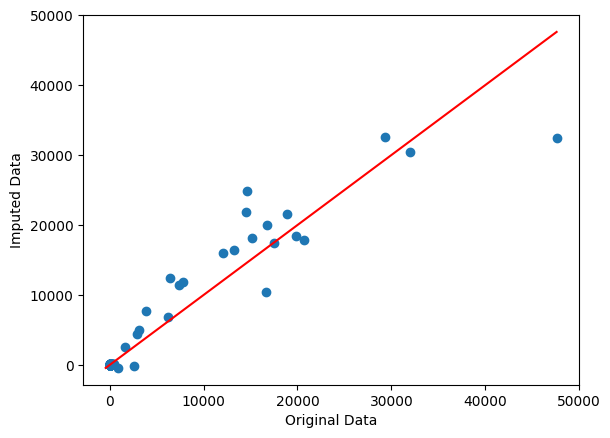

In [ ]:
M = 1
X_approximation = approximate_missing_values(Xna,M,1e-3)
nan_indices = np.where(pd.isna(Xna))
plotResults(X, X_approximation, False,nan_indices)